# House Price Prediction - Model Training Pipeline

This notebook trains a Random Forest model to predict house sale prices using the Ames Housing dataset.
We'll explore the data, clean it, engineer features, and compare different models.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [35]:
# --- LOAD DATA ---
ames_housing = pd.read_csv("../data/ames-housing.csv")

In [36]:
# --- DATA CLEANING ---
ames_housing.columns = (
    ames_housing.columns.str.strip().str.replace(" ", "", regex=False)
)

In [37]:
# --- TARGET SEARATION ---
target_name = "SalePrice"
X = ames_housing.drop(columns=target_name)
y = ames_housing[target_name]

In [38]:
# --- REMOVE USELESS COLUMNS ---
useless_columns = ["Order", "PID"]
X = X.drop(columns=useless_columns)

In [39]:
# --- CLEAN WHITESPACES ---
string_cols = X.select_dtypes(include=["object", "string"]).columns
X[string_cols] = X[string_cols].apply(lambda col: col.str.strip())

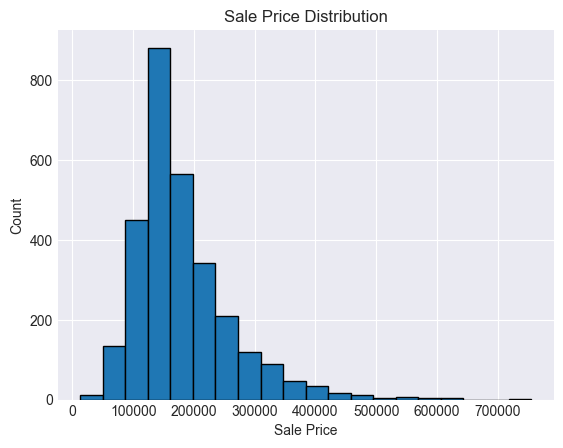

In [40]:
# --- EXPLORE TARGET ---
plt.hist(y, bins=20, edgecolor="black")
plt.title("Sale Price Distribution")
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.show()

In [41]:
# --- CHECK MISSING VALUES ---
def divider():
    print("\n" + "=" * 75 + "\n")
missing_values = X.isnull().sum()
divider()
print("MISSING VALUES PER COLUMN:")
divider()
print(missing_values[missing_values > 0])
divider()
# --- CHECK UNIQUE VALUES IN CATEGORICAL FEATURES ---
print("UNIQUE VALUES IN CATEGORICAL FEATURES:")
divider()
for col in X.select_dtypes(include=["object", "string"]).columns:
    unique_values = X[col].nunique()
    print(f"{col}: {unique_values} unique values")

# --- CHECK CORRELATION WITH TARGET ---
correlations = X.select_dtypes(include=["int64", "float64"]).corrwith(y)
divider()
print("CORRELATION WITH SALE PRICE\nThe correlation with Sale Price indicates how strongly each numeric feature\nis linearly related to the target variable (Sale Price).\nIt is calculated using Pearson's correlation coefficient, which ranges from -1 to 1.\nA value close to 1 means a strong positive correlation, a value close to -1 means a strong negative correlation,\nand a value around 0 means no linear correlation.")
print("CORRELATION WITH SALE PRICE:")
divider()
print(correlations.sort_values(ascending=False))
divider()



MISSING VALUES PER COLUMN:


LotFrontage      490
Alley           2732
MasVnrType      1775
MasVnrArea        23
BsmtQual          80
BsmtCond          80
BsmtExposure      83
BsmtFinType1      80
BsmtFinSF1         1
BsmtFinType2      81
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
FireplaceQu     1422
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2917
Fence           2358
MiscFeature     2824
dtype: int64


UNIQUE VALUES IN CATEGORICAL FEATURES:


MSZoning: 7 unique values
Street: 2 unique values
Alley: 2 unique values
LotShape: 4 unique values
LandContour: 4 unique values
Utilities: 3 unique values
LotConfig: 5 unique values
LandSlope: 3 unique values
Neighborhood: 28 unique values
Condition1: 9 unique values
Condition2: 8 unique values
BldgType: 5 unique values
HouseStyle: 8 unique val

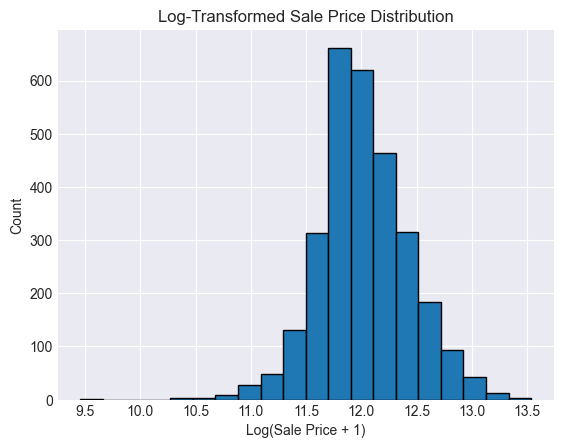

In [42]:
# --- APPLY LOG TRANSFORMATION TO THE TARGET VARIABLE TO REDUCE SKEWNESS ---
y_log = np.log1p(y)
plt.hist(y_log, bins=20, edgecolor="black")
plt.title("Log-Transformed Sale Price Distribution")
plt.xlabel("Log(Sale Price + 1)")
plt.ylabel("Count")
plt.show()

In [43]:
# --- SEPARATE NUMERIC AND CATEGORICAL FEATURES ---
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object", "string"]).columns

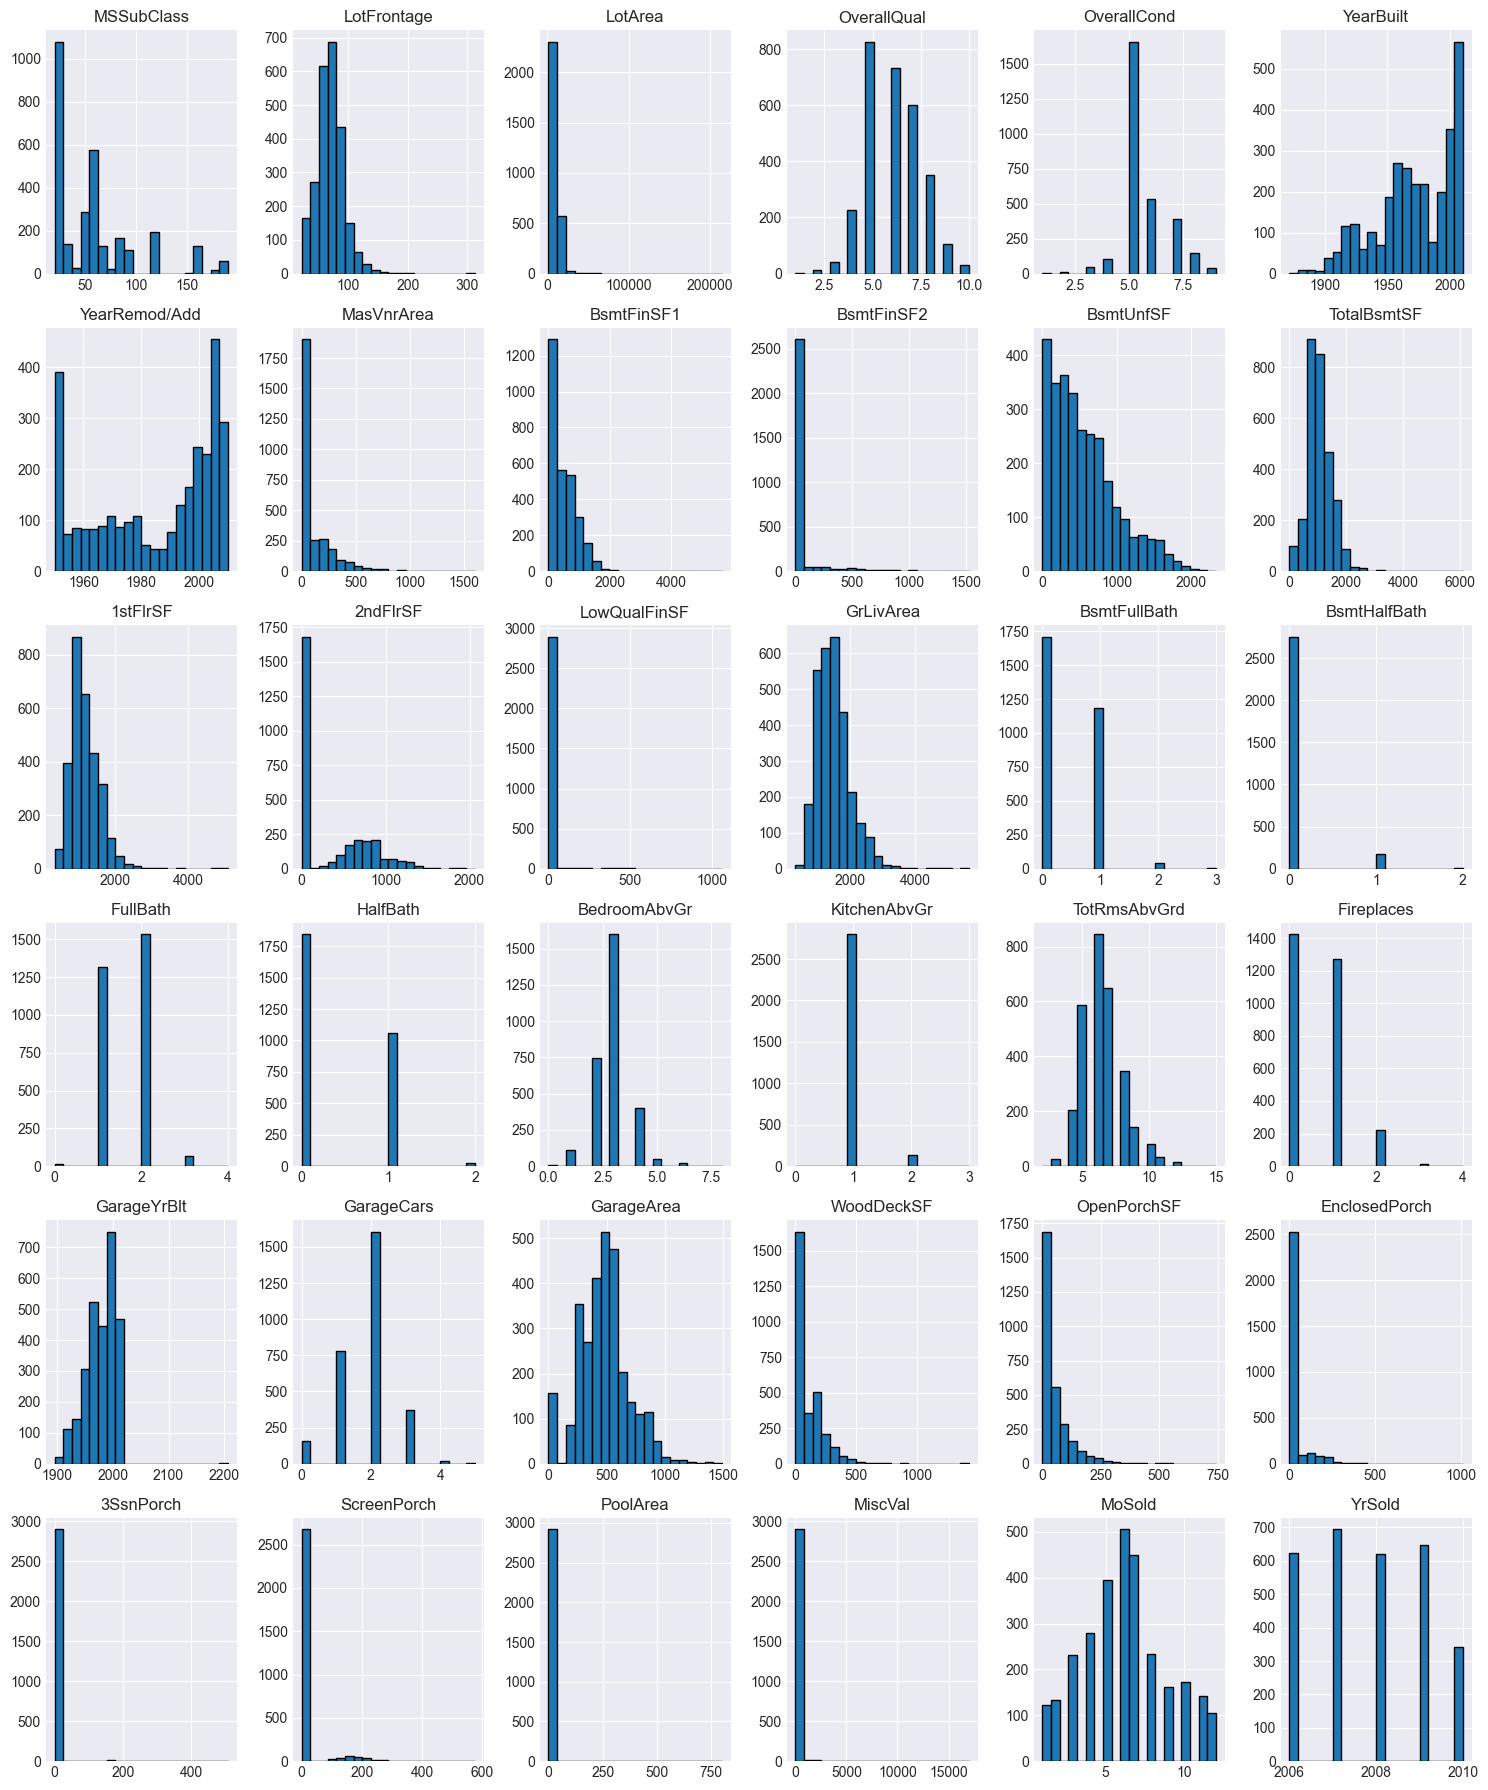

In [44]:
# --- PLOT NUMERIC HISTOGRAMS ---
X[numeric_features].hist(
    bins=20,
    edgecolor="black",
    figsize=(15, 2 * len(numeric_features) // 4)
)
plt.tight_layout()
plt.show()

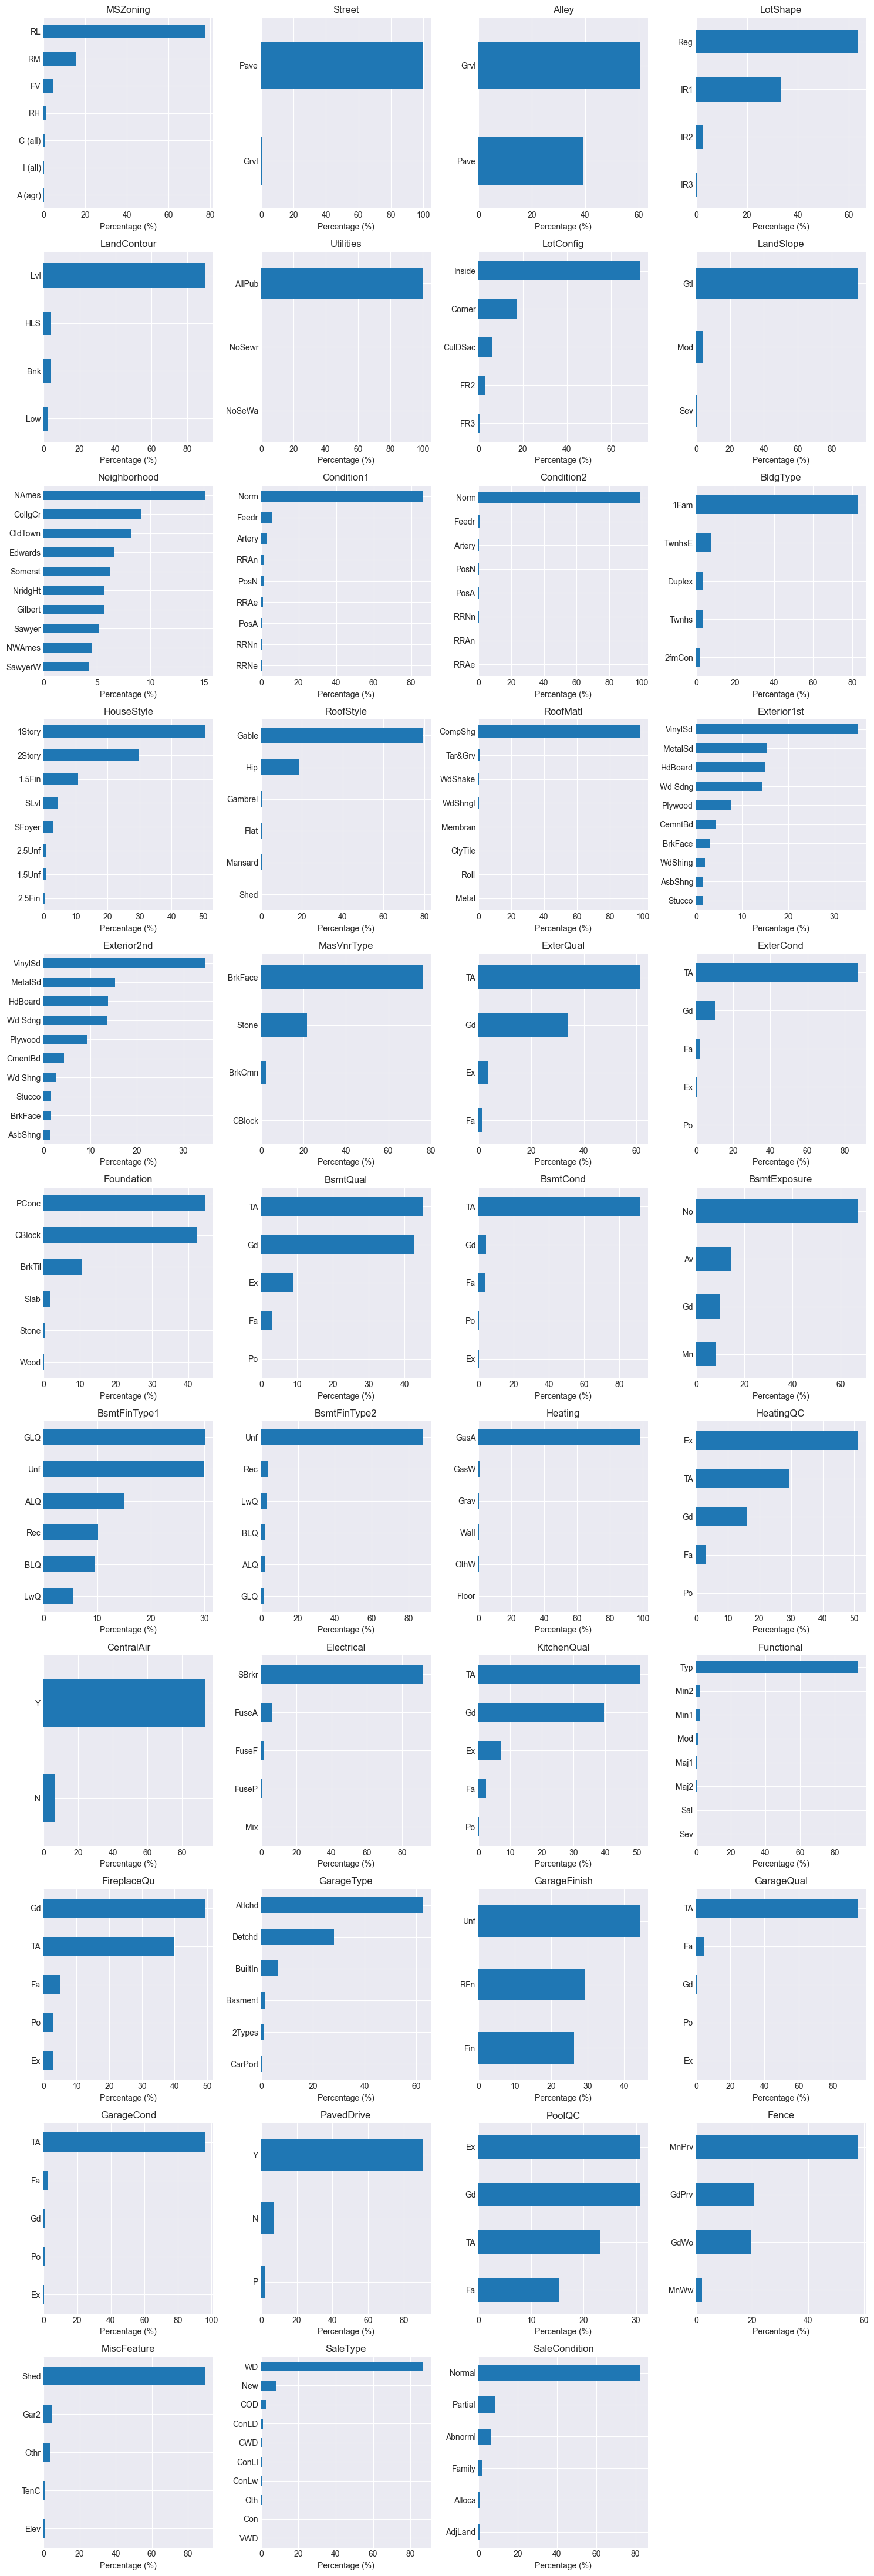

In [45]:
# --- PLOT CATEGORICAL DISTRIBUTIONS ---
def plot_categorical_distributions(df, cols_per_row=4, top_n=10):
    n_features = len(df.columns)
    n_rows = math.ceil(n_features / cols_per_row)

    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for ax, col in zip(axes, df.columns):
        counts = df[col].value_counts(normalize=True).mul(100)

        if top_n:
            counts = counts.head(top_n)

        counts.sort_values().plot(kind="barh", ax=ax)
        ax.set_title(col)
        ax.set_xlabel("Percentage (%)")
        ax.set_ylabel("")

    for ax in axes[n_features:]:
        ax.axis("off")

    fig.tight_layout()
    fig.show()

plot_categorical_distributions(X[categorical_features])

In [46]:
# --- BUILD PREPROCESSOR ---
# Numeric: median imputation
numeric_imputer = SimpleImputer(strategy="median")

# Categorical: most frequent imputation + OneHotEncoding
categorical_imputer = SimpleImputer(strategy="most_frequent")
categorical_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
categorical_pipeline = make_pipeline(categorical_imputer, categorical_encoder)

preprocessor = make_column_transformer(
    (numeric_imputer, numeric_features),
    (categorical_pipeline, categorical_features)
)

In [47]:
# --- FULL PIPELINE WITH LINEAR REGRESSION---
model = make_pipeline(
    preprocessor,
    LinearRegression()
)

In [48]:
# --- CROSS VALIDATE MODEL ---
scores = cross_val_score(model, X, y, cv=5, scoring="r2")
print(f"Cross-validated R² scores: {scores}")
print(f"Mean R² score: {scores.mean():.4f}")

Cross-validated R² scores: [0.90896148 0.90523193 0.79973258 0.7813664  0.90088531]
Mean R² score: 0.8592


In [49]:
# --- FIT FINAL MODEL ---
model.fit(X, y)
print("Model training successfully!")

Model training successfully!


In [50]:
# --- FULL PIPELINE WITH RANDOM FOREST REGRESSOR ---
model_rf = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
)

In [51]:
# --- CROSS VALIDATE RANDOM FOREST MODEL (WITH LOG-TRANSFORMED TARGET) ---
scores_rf = cross_val_score(model_rf, X, y_log, cv=5, scoring="r2")
print(f"Cross-validated R² scores (Random Forest): {scores_rf}")
print(f"Mean R² score (Random Forest): {scores_rf.mean():.4f}")

Cross-validated R² scores (Random Forest): [0.86920008 0.89814539 0.86844678 0.86882496 0.90279319]
Mean R² score (Random Forest): 0.8815


In [52]:
# --- FIT FINAL MODEL ---
model.fit(X, y_log)
print("Random Forest model training successfully!")

Random Forest model training successfully!


In [53]:
# --- INVERSE TRANSFORM PREDICTIONS TO ORIGINAL SCALE ---
y_pred_log = model.predict(X)
y_pred = np.expm1(y_pred_log)
print("Predictions on original scale:")
print(y_pred[:10])

Predictions on original scale:
[208733.48631802 120173.8474339  163772.62281299 268096.26681812
 179959.0720829  197411.37499815 217754.09082861 198585.77594279
 245785.8464565  194035.93129144]


In [54]:
#✅ Key Takeaways:
# Random Forest > Linear Regression for this dataset:\n
# Better handles non-linear effects and categorical features with many levels.\n
# More robust to outliers.
# Log-transform target helped make the model training more stable.
# Cross-validation shows Random Forest is more consistent across folds — fewer drastic dips in performance.